<b>COSMIC RADIATION: deep learning</b>
    
rodrigoX: Contains 4 parameters
    1. NALLParticlesTotal : Total number of particles generated by the event in the ground level.
    2. MUTotal : Total number of muons.
    3. ELTotal : Total number of electromagnetic particles.
    4. Zenith : Zenith angle of the particle [degrees].
    5. Energy : Particle energy [GeV].

rodrigoY: contains the target
    Labels: photon, proton, helium, nitrogen, iron.
        the smallest number is assigned to photon (A=0) and the highest number to the heaviest particle, this is, iron (B=4).
        
        0==photon     1==proton    2==helium     3==nitrogen   4==iron 
     

In [25]:
import pandas as pd
import tensorflow as tf

from tensorflow import keras

In [26]:
from tensorflow.keras.layers import BatchNormalization

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.layers import Dropout

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline


In [75]:
#Load it back:
model = tf.keras.models.load_model('cosmic_radiation.model')
#to save the model
#model.save('cosmic_radiation.model')

### Data

In [28]:
#leave the dataset ready
df_x = pd.read_fwf('XRodrigo.txt')
df_x.columns = ["NALLParticlesTotal", "MUTotal", "ELTotal", "Zenith","Energy"]
df_y=pd.read_fwf('YRodrigo.txt')
df_y.columns = ["Particle"]

transpose=df_x.T
transpose_y=df_y.T #Transpose to put them together
df_tot = transpose.append(transpose_y)
df_tot=df_tot.T.sample(frac=1).reset_index(drop=True)#este el el df completo y barajado

df_y=df_tot[['Particle']]
df_x=df_tot[["NALLParticlesTotal", "MUTotal", "ELTotal", "Zenith","Energy"]]

In [29]:
#train-test split and reescale
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, random_state=0,test_size = 0.25)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_train_np=y_train.to_numpy()
y_test_np=y_test.to_numpy()

### Model 

In [79]:
from tensorflow.keras.layers import BatchNormalization
# from tensorflow.keras.layers import Dropout

model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Dense(128, use_bias=False,kernel_initializer='he_uniform', activation=tf.nn.relu))
model.add(BatchNormalization())
model.add(tf.keras.layers.Dropout(0.0))

model.add(tf.keras.layers.Dense(128, use_bias=False,kernel_initializer='he_uniform', activation=tf.nn.relu))
model.add(BatchNormalization())
model.add(tf.keras.layers.Dropout(0.0))

model.add(tf.keras.layers.Dense(128, use_bias=False,kernel_initializer='he_uniform', activation=tf.nn.relu))
model.add(BatchNormalization())
model.add(tf.keras.layers.Dropout(0.0))



model.add(tf.keras.layers.Dense(5, activation=tf.nn.softmax))

# N_TRAIN=X_train.shape[0];BATCH_SIZE=128
# STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE
# lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay( 0.001,decay_steps=STEPS_PER_EPOCH*500,decay_rate=1,staircase=False)
# #STEPS_PER_EPOCH*300-->The code above sets a schedules.InverseTimeDecay to hyperbolically decrease the learning rate to 1/2 of the base rate at 300 epochs, 1/3 at 600 epochs and so on.

optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

model.compile(optimizer=optimizer , loss='sparse_categorical_crossentropy',metrics=['accuracy'])
#If I want to know the weights of a layer:
#model.layers[1].get_weights()


In [83]:
%%time
history=model.fit(X_train, y_train_np, epochs=500, batch_size=128, validation_data=(X_test, y_test))


In [88]:
val_loss, val_acc = model.evaluate(X_test, y_test_np)
# print(val_loss)
print(val_acc)
#model.summary()
#model.get_config()
#model.get_weights()

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
y_pred= model.predict_classes(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, datatest))

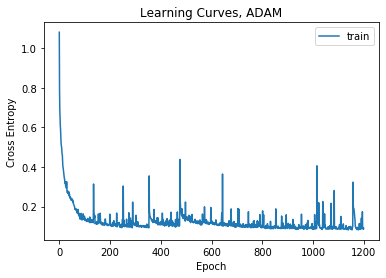

In [72]:
from matplotlib import pyplot
history1=history
# plot learning curves
pyplot.title('Learning Curves, ADAM')
pyplot.xlabel('Epoch')
pyplot.ylabel('Cross Entropy')
pyplot.plot(history.history['loss'], label='train')
#pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()
pyplot.show()

### Grid Search

In [6]:
#Shouls chage
import numpy
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Dense
from keras.optimizers import Adam
from keras.layers import BatchNormalization
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

In [9]:
def create_model(neurons=128,optimizer='adam',learn_rate=0.001, init_mode='he_normal', activation='relu', dropout_rate=0.0, weight_constraint=0):#parameters here are default
    #create model
    model = tf.keras.models.Sequential()
    #los weight_initializer son mas optimos dependiendo de la funcion de activacion
    model.add(tf.keras.layers.Dense(neurons, use_bias=False, kernel_initializer=init_mode, activation=activation))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.Dropout(dropout_rate))
    
    model.add(tf.keras.layers.Dense(neurons, use_bias=False, kernel_initializer=init_mode, activation=activation))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.Dropout(dropout_rate))
    
    model.add(tf.keras.layers.Dense(5, activation='softmax'))
    
    #aqui estoy obligando a que el optimizer sea adam. Deberia decir: if optimizer=='adam' then... y hacerlo para otros optimizadores
    optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate, beta_1=0.9, beta_2=0.999, amsgrad=False)
    #compile model        https://keras.io/models/model/
    model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    return model

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
model = KerasClassifier(build_fn=create_model, epochs=25, batch_size=64, verbose=1) #if I add any param here has to be in the model(there has to be a default value)#de values that I set here are definitive

In [14]:
# PARAMETERS  SI QUIERO CUALQUIER PARAMETRO QUE NO SEA EL DEFAULT LO PONGO AQUI ABAJO
batch_size = [128,264]
epochs = [5]
optimizer = ['Adam','Nadam','Adagrad']#,'SGD', 'RMSprop', 'Adagrad', 'Adadelta',  'Adamax', 'Nadam']
learn_rate = [0.001,0.01,0.05]#[0.001, 0.01, 0.1, 0.2, 0.3]
momentum = [0]#[0.0, 0.2, 0.4, 0.6, 0.8, 0.9]  #en este caso momentum es para SGD por ej., para adam solo se usa learn. rate
activation = ['relu']#['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
init_mode = ['he_normal','he_uniform']#['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
weight_constraint = [0]#[1, 2, 3, 4, 5]
dropout_rate =[0] #[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
neurons = [32,64,128,256] #[5, 10, 15, 20, 25, 30]

param_grid = dict(epochs=epochs,batch_size=batch_size,optimizer=optimizer, init_mode=init_mode, neurons=neurons )


In [15]:
#FIT GRID SEARCH
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5, verbose=1)
#FIT RANDOM GRID SEARCH
#grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_jobs=-1, cv=2)
grid_result = grid.fit(X_train, y_train_np)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   41.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  4.2min finished


Epoch 1/5
31493/31493 [==============================] - 1s 17us/step - loss: 1.4484 - accuracy: 0.3674
Epoch 2/5
31493/31493 [==============================] - 0s 14us/step - loss: 1.0888 - accuracy: 0.5987
Epoch 3/5
31493/31493 [==============================] - 0s 13us/step - loss: 0.9006 - accuracy: 0.6985
Epoch 4/5
31493/31493 [==============================] - 0s 12us/step - loss: 0.7923 - accuracy: 0.7461
Epoch 5/5
31493/31493 [==============================] - 0s 12us/step - loss: 0.7258 - accuracy: 0.7671


In [96]:
# summarize results

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.802337 using {'batch_size': 128, 'epochs': 5, 'init_mode': 'he_uniform', 'neurons': 32, 'optimizer': 'Nadam'}


In [61]:
results = pd.DataFrame(grid_result.cv_results_)
results.to_csv('random-grid-search-results-01.csv', index=False)

In [62]:
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_batch_size,param_epochs,param_init_mode,param_neurons,param_optimizer,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.391154,0.096141,0.384372,0.040880,128,5,he_normal,32,Adam,"{'batch_size': 128, 'epochs': 5, 'init_mode': ...",0.700270,0.679790,0.758057,0.630676,0.689584,0.691676,0.040858,33
1,2.659888,0.099530,0.179922,0.044196,128,5,he_normal,32,Nadam,"{'batch_size': 128, 'epochs': 5, 'init_mode': ...",0.779171,0.787109,0.741705,0.790092,0.748809,0.769377,0.020141,11
2,1.781811,0.043954,0.217328,0.051169,128,5,he_normal,32,Adagrad,"{'batch_size': 128, 'epochs': 5, 'init_mode': ...",0.628195,0.598190,0.632640,0.695300,0.583042,0.627474,0.038625,44
3,2.620494,0.193933,0.200297,0.042915,128,5,he_normal,64,Adam,"{'batch_size': 128, 'epochs': 5, 'init_mode': ...",0.702651,0.761867,0.749960,0.787234,0.753255,0.750994,0.027476,14
4,2.996305,0.298421,0.207844,0.047457,128,5,he_normal,64,Nadam,"{'batch_size': 128, 'epochs': 5, 'init_mode': ...",0.789967,0.800286,0.837276,0.766751,0.787710,0.796398,0.023160,2
5,2.367496,0.380685,0.226120,0.056022,128,5,he_normal,64,Adagrad,"{'batch_size': 128, 'epochs': 5, 'init_mode': ...",0.753453,0.700270,0.729798,0.741188,0.725786,0.730099,0.017759,21
6,3.437501,0.275093,0.281184,0.058450,128,5,he_normal,128,Adam,"{'batch_size': 128, 'epochs': 5, 'init_mode': ...",0.722496,0.848071,0.736149,0.741505,0.825341,0.774712,0.051500,9
7,4.317676,0.416782,0.339747,0.096444,128,5,he_normal,128,Nadam,"{'batch_size': 128, 'epochs': 5, 'init_mode': ...",0.841403,0.800445,0.751230,0.848841,0.729120,0.794208,0.047612,3
8,3.829948,0.295035,0.357485,0.121151,128,5,he_normal,128,Adagrad,"{'batch_size': 128, 'epochs': 5, 'init_mode': ...",0.722019,0.739165,0.772345,0.783582,0.725945,0.748611,0.024885,15
9,6.351973,0.540787,0.470245,0.143196,128,5,he_normal,256,Adam,"{'batch_size': 128, 'epochs': 5, 'init_mode': ...",0.774726,0.777743,0.852040,0.723563,0.763417,0.778298,0.041637,7


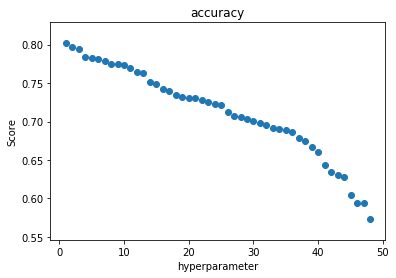

In [97]:
# plot learning curves
pyplot.title('accuracy')
pyplot.xlabel('hyperparameter')
pyplot.ylabel('Score')
pyplot.scatter(grid_result.cv_results_['rank_test_score'],grid_result.cv_results_['mean_test_score'] )
pyplot.show()